In [1]:
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
pip install scanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import issparse
import scanpy as sc


from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [4]:
# Read data

adata = sc.read_h5ad('/content/drive/MyDrive/USYD/2021 S1/INFO4001/2022-re/Leukemia.h5ad')




if not issparse(adata.X):
    adata.X = scipy.sparse.csr_matrix(adata.X)


adata.var_names_make_unique()


In [5]:
#Preprocessing 

print('Raw dataset shape: {}'.format(adata.shape))

if not issparse(adata.X):
    adata.X = scipy.sparse.csr_matrix(adata.X)

adata.X[adata.X>1] = 1

# Filtering  data
'''
filter low quality peaks by valid cells number, default 0.01
filter low quality cells by valid peaks number, default 100
filter peaks by selecting highly variable features, default 100,000
''' 
min_cells = 0.01
min_genes = 100
n_features = 100000


#Filtering  cells 
sc.pp.filter_cells(adata, min_genes=min_genes)


#Filtering  genes
if min_cells <1:
    min_cells = min_cells * adata.shape[0]
sc.pp.filter_genes(adata, min_cells=min_cells)

sc.pp.highly_variable_genes(adata, n_top_genes=n_features, inplace=False, subset=True)

print('Processed dataset shape: {}'.format(adata.shape))

Raw dataset shape: (391, 7602)
Processed dataset shape: (352, 7537)


In [6]:

df = adata.to_df()

In [7]:
# processing y
index = df.index
mt_y = index.to_numpy()
for i in range(len(mt_y)):
    mt_y[i] = "_".join(mt_y[i].split("_")[:-1])

In [8]:
# split data to train and test 
mt = df.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(
    mt, mt_y, test_size=0.2,stratify=mt_y, random_state=42,shuffle=True)

unique_classes = np.unique(mt_y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(unique_classes)
print(len(unique_classes))

(281, 7537) (71, 7537) (281,) (71,)
['BM1077_LMPP_Frozen_160107' 'singles_PB1022_mono_160128'
 'singles_SU070_140806_Leuk' 'singles_SU070_LSC_141210'
 'singles_SU353_Blast_160205' 'singles_SU353_LSC_160209']
6


In [9]:
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
import inspect
from numpy.fft import fft
from numpy.fft import fftshift


class LogScaler:
    #Log normalization and data scaling
    
    def __init__(self):
        self._min0 = None
        self._max = None
        pass

    def fit(self, X, y=None):
        self._min0 = X.min(axis=0)
        self._max = np.log(X + np.abs(self._min0) + 1).max()

    def fit_transform(self, X, y=None):
        self._min0 = X.min(axis=0)
        X_norm = np.log(X + np.abs(self._min0) + 1)
        self._max = X_norm.max()
        return X_norm / self._max

    def transform(self, X, y=None):
        X_norm = np.log(X + np.abs(self._min0) + 1).clip(0, None)
        return (X_norm / self._max).clip(0, 1)


class FftTransformer:
    # Image transformer based on fast fourier transform

    def __init__(self, pixels=124):
        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        self._xrot = None

    def fft_fit(self,X):     
        z1_lst=[]
        z2_lst=[]

        for cur_x in range(len(X)):
            x_ft = fftshift(fft(X[cur_x]))
                 
            real_lst =[0]*len(x_ft)
            imag_lst= [0]*len(x_ft)

            for i in range(len(x_ft)):
                real_lst[i] = x_ft[i].real
                imag_lst[i] = x_ft[i].imag

            q1, q3 = np.percentile(sorted(real_lst), [10, 90])
            iqr = q3 - q1
    
            # find lower and upper bounds
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)

            outliers=[]
            outliers_idx=[]
            for i in range(len(real_lst)):
                if real_lst[i] <= lower_bound or real_lst[i] >= upper_bound:
                    outliers.append(real_lst[i])
                    outliers_idx.append(i)
            
            for i in range(len(outliers_idx)):
                real_lst[outliers_idx[i]]=0
            
            # imag 
            q1, q3 = np.percentile(sorted(imag_lst), [10, 90])
            iqr = q3 - q1
    
            # find lower and upper bounds
            lower_bound = q1 - (1.5 * iqr)
            upper_bound = q3 + (1.5 * iqr)

            outliers=[]
            outliers_idx=[]
            for i in range(len(imag_lst)):
                if imag_lst[i] <= lower_bound or imag_lst[i] >= upper_bound:
                    outliers.append(imag_lst[i])
                    outliers_idx.append(i)
            
            for i in range(len(outliers_idx)):
                imag_lst[outliers_idx[i]]=0

            z1_lst.append(np.array(real_lst))
            z2_lst.append(np.array(imag_lst))
    
        z1_lst = np.mean(np.array(z1_lst),axis=0) 
        z2_lst = np.mean(np.array(z2_lst),axis=0)

        real_mt = np.empty(shape=(x_ft.shape[0],1))
        real_mt.fill(0)
        imag_mt = np.empty(shape=(x_ft.shape[0],1))
        imag_mt.fill(0)

        for i in range(len(x_ft)):
            cur_real = z1_lst[i]
            real_mt[i] = cur_real

            cur_imag = z2_lst[i]
            imag_mt[i] = cur_imag

        z1 = real_mt
        z2 = imag_mt
        full_mt = np.hstack((z1,z2))
    
        return full_mt

    def fit(self, X, y=None, plot=False):
        x_new = self.fft_fit(X)        

        # get the convex hull for the points
        chvertices = ConvexHull(x_new).vertices

        hull_points = x_new[chvertices]

        # get minimum bounding rectangle
        mbr, mbr_rot = self._minimum_bounding_rectangle(hull_points)
        
        # matrix rotation
        self._xrot = np.dot(mbr_rot, x_new.T).T
        
        # get feature coordinates from pixel dimension
        self._calculate_coords()

        #  rotation diagram plot
        if plot is True:
            plt.scatter(x_new[:, 0], x_new[:, 1], s=1,
                        cmap=plt.cm.get_cmap("jet", 10), alpha=0.2)
            plt.fill(x_new[chvertices, 0], x_new[chvertices, 1],
                     edgecolor='r', fill=False)
            plt.fill(mbr[:, 0], mbr[:, 1], edgecolor='g', fill=False)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.show()
        return self

    @property
    def pixels(self):
        # Image matrix dimensions
        # Returns:
        #     tuples: (height, width)

        return self._pixels

    @pixels.setter
    def pixels(self, pixels):
        # set image matrix dimension

        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        # recalculate coordinates if already fit
        if hasattr(self, '_coords'):
            self._calculate_coords()

    def _calculate_coords(self):

        # Calculate matrix coordinates of each feature based on the pixel dimensions


        cur_xrp = self._xrot[:, 0]
        cur_yrp = self._xrot[:, 1] 

        ax0_coord = np.digitize(
            cur_xrp,
            bins=np.linspace(min(cur_xrp), max(cur_xrp),
                             self._pixels[0])
        ) - 1
        ax1_coord = np.digitize(
            cur_yrp,
            bins=np.linspace(min(cur_yrp), max(cur_yrp),
                             self._pixels[1])
        ) - 1

        self._coords = np.stack((ax0_coord, ax1_coord), axis=1)

    def transform(self, X):
 
        img_coords = pd.DataFrame(np.vstack((
            self._coords.T,
            X
        )).T).groupby([0, 1], as_index=False).mean()

        img_matrices = []
        blank_mat = np.zeros(self._pixels)
        
        for z in range(2, img_coords.shape[1]):
            img_matrix = blank_mat.copy()
            img_matrix[img_coords[0].astype(int),
                       img_coords[1].astype(int)] = img_coords[z]
            img_matrices.append(img_matrix)

    
        img_matrices = np.array([self._mat_to_rgb(m) for m in img_matrices])
        
        return img_matrices

    def fit_transform(self, X, **kwargs):

        self.fit(X)
        return self.transform(X, **kwargs)

    def feature_density_matrix(self):

        fdmat = np.zeros(self._pixels)
        np.add.at(fdmat, tuple(self._coords.T), 1)
        return fdmat

    def coords(self):
        #Get feature coordinates

        return self._coords.copy()

    @staticmethod
    def _minimum_bounding_rectangle(hull_points):
        """Find the smallest bounding rectangle for a set of points.
        Modified from JesseBuesking at https://stackoverflow.com/a/33619018
        Returns a set of points representing the corners of the bounding box.
        Args:
            hull_points : an nx2 matrix of hull coordinates
        Returns:
            (tuple): tuple containing
                coords (ndarray): coordinates of the corners of the rectangle
                rotmat (ndarray): rotation matrix to align edges of rectangle
                    to x and y
        """

        pi2 = np.pi / 2
        # calculate edge angles
        edges = hull_points[1:] - hull_points[:-1]
        angles = np.arctan2(edges[:, 1], edges[:, 0])
        angles = np.abs(np.mod(angles, pi2))
        angles = np.unique(angles)
        # find rotation matrices
        rotations = np.vstack([
            np.cos(angles),
            -np.sin(angles),
            np.sin(angles),
            np.cos(angles)]).T
        rotations = rotations.reshape((-1, 2, 2))
        # apply rotations to the hull
        rot_points = np.dot(rotations, hull_points.T)
        # find the bounding points
        min_x = np.nanmin(rot_points[:, 0], axis=1)
        max_x = np.nanmax(rot_points[:, 0], axis=1)
        min_y = np.nanmin(rot_points[:, 1], axis=1)
        max_y = np.nanmax(rot_points[:, 1], axis=1)
        # find the box with the best area
        areas = (max_x - min_x) * (max_y - min_y)
        best_idx = np.argmin(areas)
        # return the best box
        x1 = max_x[best_idx]
        x2 = min_x[best_idx]
        y1 = max_y[best_idx]
        y2 = min_y[best_idx]
        rotmat = rotations[best_idx]
        # generate coordinates
        coords = np.zeros((4, 2))
        coords[0] = np.dot([x1, y2], rotmat)
        coords[1] = np.dot([x2, y2], rotmat)
        coords[2] = np.dot([x2, y1], rotmat)
        coords[3] = np.dot([x1, y1], rotmat)

        return coords, rotmat

    @staticmethod
    def _mat_to_rgb(mat):
        """Convert image matrix to numpy rgb format
        Args:
            mat: {array-like} (M, N)
        Returns:
            An numpy.ndarry (M, N, 3) with orignal values repeated across
            RGB channels.
        """
        return np.repeat(mat[:, :, np.newaxis], 3, axis=2)

In [10]:
ln = LogScaler()

x_train_norm = ln.fit_transform(x_train)
x_test_norm = ln.transform(x_test)

In [11]:
it = FftTransformer(pixels=124)


In [12]:
pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
%load_ext memory_profiler


peak memory: 337.96 MiB, increment: 0.02 MiB


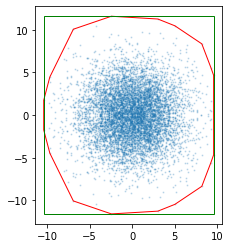

CPU times: user 4.96 s, sys: 172 ms, total: 5.13 s
Wall time: 5.52 s


In [14]:
%%time
%memit
_ =  it.fit(x_train_norm, plot=True)

In [15]:
x_train_img = it.transform(x_train_norm)
x_train_img.shape


(281, 124, 124, 3)

In [16]:
x_test_img = it.transform(x_test_norm)
x_test_img.shape

(71, 124, 124, 3)

Train img
BM1077_LMPP_Frozen_160107
singles_SU353_Blast_160205
singles_PB1022_mono_160128
singles_PB1022_mono_160128
singles_PB1022_mono_160128
singles_PB1022_mono_160128
singles_SU353_LSC_160209
singles_SU070_LSC_141210
singles_SU070_LSC_141210
singles_SU353_Blast_160205


<Figure size 1080x288 with 0 Axes>

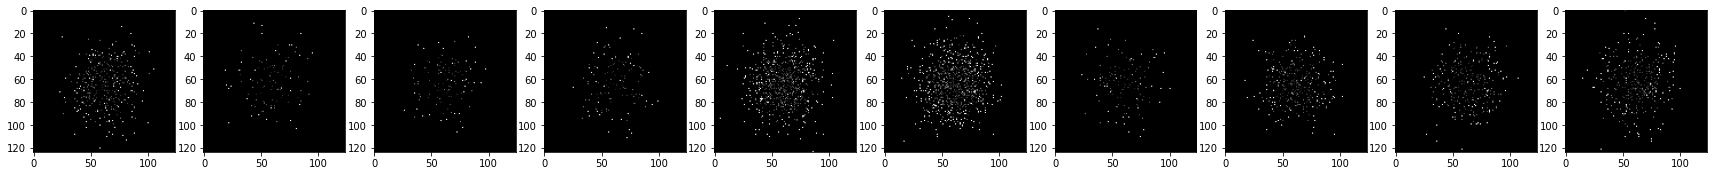

In [17]:
print("Train img")
plt.figure(figsize=(15,4))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,10,figsize=(30,30)) 

for i in range(10):
    axarr[i].imshow(x_train_img[i])
    print(y_train[i])

Test img
BM1077_LMPP_Frozen_160107
singles_SU353_Blast_160205
singles_PB1022_mono_160128
singles_PB1022_mono_160128
singles_PB1022_mono_160128
singles_PB1022_mono_160128
singles_SU353_LSC_160209
singles_SU070_LSC_141210
singles_SU070_LSC_141210
singles_SU353_Blast_160205


<Figure size 1080x288 with 0 Axes>

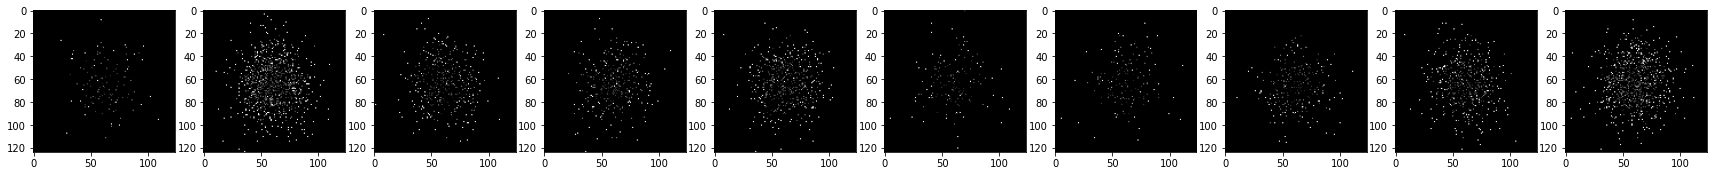

In [18]:
print("Test img")
plt.figure(figsize=(15,4))
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,10,figsize=(30,30)) 

for i in range(10):   
    axarr[i].imshow(x_test_img[i])
    print(y_train[i])


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras import layers
import numpy as np

In [20]:

label = unique_classes.tolist()

n_lst=[]
for i in range(len(y_train)):
  for j in range(len(label)):
    if y_train[i] == label[j]:

      n_lst.append(j)

y_new_train = np.array(n_lst,dtype='float64')

n_lst=[]
for i in range(len(y_test)):
  for j in range(len(label)):
    if y_test[i] == label[j]:
      n_lst.append(j)

y_new_test = np.array(n_lst,dtype='float64')

In [21]:
df_y_train = to_categorical(y_new_train,num_classes=len(label))

In [22]:
from keras.callbacks import EarlyStopping, ModelCheckpoint , ReduceLROnPlateau


model = Sequential()
model.add(Conv2D(64,(3,3),input_shape=(124,124,3)) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3) ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(len(label)))
model.add(Activation('sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1, min_delta=1e-4, mode='auto')

model.fit(x_train_img, df_y_train, batch_size=32, epochs=90, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.2)

Epoch 1/90
7/7 [==============================] - 9s 1s/step - loss: 2.0883 - accuracy: 0.3080 - val_loss: 1.7586 - val_accuracy: 0.3509 - lr: 0.0010
Epoch 2/90
7/7 [==============================] - 8s 1s/step - loss: 1.6172 - accuracy: 0.6161 - val_loss: 1.6437 - val_accuracy: 0.3509 - lr: 0.0010
Epoch 3/90
7/7 [==============================] - 8s 1s/step - loss: 1.2880 - accuracy: 0.7232 - val_loss: 1.3295 - val_accuracy: 0.5614 - lr: 0.0010
Epoch 4/90
7/7 [==============================] - 8s 1s/step - loss: 0.6943 - accuracy: 0.8214 - val_loss: 1.0246 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 5/90
7/7 [==============================] - 8s 1s/step - loss: 0.2176 - accuracy: 0.9821 - val_loss: 0.9073 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/90
7/7 [==============================] - 8s 1s/step - loss: 0.0577 - accuracy: 0.9955 - val_loss: 1.0118 - val_accuracy: 0.6491 - lr: 0.0010
Epoch 7/90
7/7 [==============================] - 10s 1s/step - loss: 0.0122 - accuracy: 1.0000 - va

In [23]:
df_y_test = to_categorical(y_new_test,num_classes=len(label))

val_loss, val_acc = model.evaluate(x_test_img,df_y_test)
print(val_loss, val_acc)

3/3 [==============================] - 1s 169ms/step - loss: 1.2188 - accuracy: 0.7183
1.2188218832015991 0.7183098793029785


In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

y_pred = model.predict(x_test_img)
y_pred = np.argmax(y_pred,axis=1)

out_acc = accuracy_score(y_new_test, y_pred)
out_f1 = f1_score(y_new_test, y_pred,average ='micro')

print("Accuracy: {}".format(round(out_acc,4)))
print("F1 Score(micro): {}".format(round(out_f1,4)))

out_f1 = f1_score(y_new_test, y_pred,average ='macro')
print("F1 Score(macro): {}".format(round(out_f1,4)))

out_f1 = f1_score(y_new_test, y_pred,average ='weighted')
print("F1 Score(weighted): {}".format(round(out_f1,4)))

Accuracy: 0.7183
F1 Score(micro): 0.7183
F1 Score(macro): 0.5945
F1 Score(weighted): 0.6793
